# 준비

In [ ]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import plotly.express as px

In [ ]:
import gspread
from google.auth import default
creds, _ = default()
from gspread_dataframe import get_as_dataframe, set_with_dataframe

from google.cloud import bigquery
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(creds)

In [ ]:
query = """
  WITH base1 AS (
    SELECT
    extract(year FROM date(start_at, 'Asia/Seoul')) as year,
    extract(month FROM date(start_at, 'Asia/Seoul')) as month,
    extract(isoweek FROM date(start_at, 'Asia/Seoul')) as week,
    r.id as rid,
    r.member_id as mid,

    CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront'
          WHEN zone_id IN (18471, 18472, 18473) THEN 'test' ELSE 'common' END as part,

    datetime_diff(end_at, start_at, hour) as dur,
    date(start_at, 'Asia/Seoul') as sdate,
    date(end_at, 'Asia/Seoul') as edate,
    extract(hour FROM r.created_at) as chour,
    extract(hour FROM start_at) as shour,
    datetime_diff(start_at, r.created_at, day) as leadtime,


  FROM `tianjin_replica.reservation_info` r LEFT JOIN `tianjin_replica.carzone_info` z ON r.zone_id = z.id
  WHERE r.member_imaginary IN (0, 9)
  AND date(start_at, 'Asia/Seoul') BETWEEN '2023-01-01' AND '2023-12-31'
  AND z.region1 = '제주특별자치도'
  AND r.state in (1,2,3)
  )

  SELECT
    year, month, week,
    part,
    leadtime,
    count(rid) as cnt
  FROM base1
  GROUP BY year, month, week, part, leadtime
  """
df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)



# Leadtime별 예약 추이

In [ ]:
df['leadtime'].describe()

count       7873.0
mean     32.367585
std      25.011014
min           -1.0
25%           11.0
50%           27.0
75%           50.0
max           93.0
Name: leadtime, dtype: Float64

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df.groupby('leadtime')['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

fig = px.bar(summary, x='leadtime', y='proportion',
             title="각 leadtime별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime : Day'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:1.0f}%', textposition='outside')
# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(11)

,leadtime,cnt,proportion
0,-1,6,0.003982
1,0,81814,54.296883
2,1,11917,7.908866
3,2,7305,4.848054
4,3,5433,3.605678
5,4,4448,2.951971
6,5,3868,2.567047
7,6,3289,2.182786
8,7,2696,1.789234
9,8,2180,1.446784


# Leadtime 공항

In [ ]:
df_air = df[df['part']=='air']

# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df_air.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part',
             title="각 leadtime별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(11)

,part,leadtime,cnt,proportion
0,air,-1,5,0.005886
1,air,0,33101,38.968944
2,air,1,7038,8.285654
3,air,2,4830,5.686233
4,air,3,3829,4.507782
5,air,4,3317,3.905018
6,air,5,2953,3.47649
7,air,6,2589,3.047962
8,air,7,2246,2.644157
9,air,8,1808,2.128511


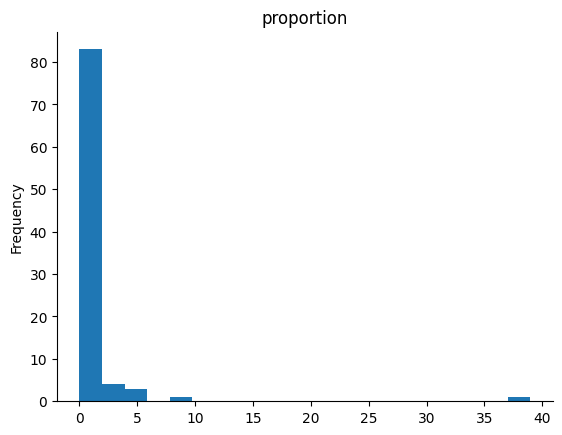

In [ ]:
# @title proportion

from matplotlib import pyplot as plt
summary['proportion'].plot(kind='hist', bins=20, title='proportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Leadtime 공항앞

In [ ]:
df_airf = df[df['part']=='air_infront']

# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df_airf.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part',
             title="각 leadtime별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(11)

,part,leadtime,cnt,proportion
0,air_infront,0,1150,35.636814
1,air_infront,1,208,6.445615
2,air_infront,2,173,5.361016
3,air_infront,3,123,3.81159
4,air_infront,4,115,3.563681
5,air_infront,5,104,3.222808
6,air_infront,6,98,3.036876
7,air_infront,7,65,2.014255
8,air_infront,8,63,1.952278
9,air_infront,9,40,1.239541


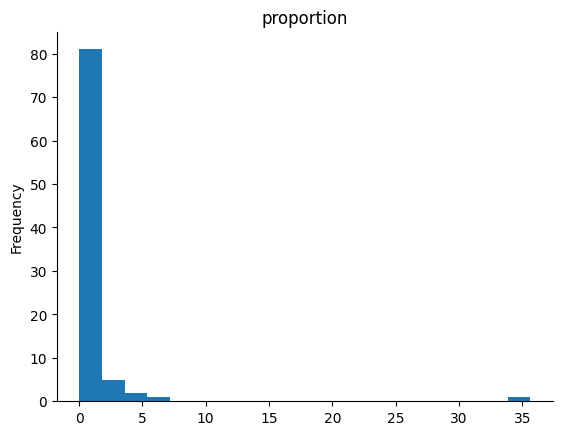

In [ ]:
# @title proportion

from matplotlib import pyplot as plt
summary['proportion'].plot(kind='hist', bins=20, title='proportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Leadtime 일반

In [ ]:
df_common = df[df['part']=='common']

# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df_common.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part',
             title="각 leadtime별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(11)

,part,leadtime,cnt,proportion
0,common,-1,1,0.001609
1,common,0,47398,76.256516
2,common,1,4645,7.473132
3,common,2,2292,3.687496
4,common,3,1462,2.352146
5,common,4,988,1.589549
6,common,5,773,1.243645
7,common,6,565,0.909003
8,common,7,368,0.592059
9,common,8,304,0.489092


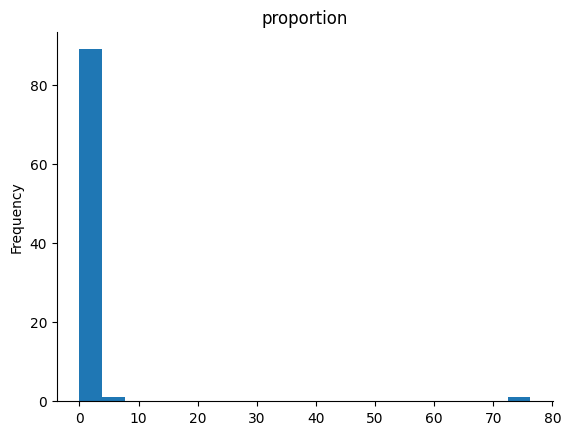

In [ ]:
# @title proportion

from matplotlib import pyplot as plt
summary['proportion'].plot(kind='hist', bins=20, title='proportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

# 준비 예약 시작시간별 예약건수 구성비

In [ ]:
query = """
  WITH base1 AS (
    SELECT
    extract(year FROM date(start_at, 'Asia/Seoul')) as year,
    extract(month FROM date(start_at, 'Asia/Seoul')) as month,
    extract(isoweek FROM date(start_at, 'Asia/Seoul')) as week,
    r.id as rid,
    r.member_id as mid,

    CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront'
          WHEN zone_id IN (18471, 18472, 18473) THEN 'test' ELSE 'common' END as part,

    datetime_diff(end_at, start_at, hour) as dur,
    date(start_at, 'Asia/Seoul') as sdate,
    date(end_at, 'Asia/Seoul') as edate,
    extract(hour FROM r.created_at) as chour,
    extract(hour FROM start_at) as shour,
    datetime_diff(start_at, r.created_at, day) as leadtime,


  FROM `tianjin_replica.reservation_info` r LEFT JOIN `tianjin_replica.carzone_info` z ON r.zone_id = z.id
  WHERE r.member_imaginary IN (0, 9)
  AND date(start_at, 'Asia/Seoul') BETWEEN '2023-01-01' AND '2023-12-31'
  AND z.region1 = '제주특별자치도'
  AND r.state in (1,2,3)
  )

  SELECT
    year, month, week,
    part,
    shour,
    count(rid) as cnt
  FROM base1
  GROUP BY year, month, week, part, shour
  """
df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

# 예약 시작시간별 예약건수 구성비

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df.groupby('shour')['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

fig = px.bar(summary, x='shour', y='proportion',
             title="각 shour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'shour': 'shour : Hour'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:1.0f}%', textposition='outside')
# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(24)

,shour,cnt,proportion
0,0,13439,8.91896
1,1,14087,9.349013
2,2,13887,9.216281
3,3,13253,8.795519
4,4,12704,8.431168
5,5,11165,7.409792
6,6,9880,6.556985
7,7,8689,5.766563
8,8,7388,4.903138
9,9,6407,4.252086


# 예약 시작시간별 예약건수 구성비 - 공항

In [ ]:
df_air = df[df['part']=='air']

# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary_air = df_air.groupby(['part', 'shour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary_air['cnt'].sum()

# 비율을 계산합니다.
summary_air['proportion'] = (summary_air['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary_air, x='shour', y='proportion', color='part',
             title="각 shour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'shour': 'Reservation Start hour', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary_air.head(24)

,part,shour,cnt,proportion
0,air,0,8029,9.452332
1,air,1,7442,8.761272
2,air,2,7119,8.381013
3,air,3,7223,8.503449
4,air,4,7481,8.807186
5,air,5,6951,8.183231
6,air,6,6233,7.337948
7,air,7,5279,6.214829
8,air,8,4165,4.903346
9,air,9,2902,3.416449


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['shour'].plot(kind='hist', bins=20, title='shour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['cnt'].plot(kind='hist', bins=20, title='cnt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['proportion'].plot(kind='hist', bins=20, title='proportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='shour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='shour', y='cnt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='cnt', y='proportion', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['shour']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('shour')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['cnt']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('cnt')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['proportion']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('proportion')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['shour'].plot(kind='line', figsize=(8, 4), title='shour')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['cnt'].plot(kind='line', figsize=(8, 4), title='cnt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['proportion'].plot(kind='line', figsize=(8, 4), title='proportion')
plt.gca().spines[['top', 'right']].set_visible(False)

# 예약 시작시간별 예약건수 구성비 - 공항 앞

In [ ]:
df_airf = df[df['part']=='air_infront']

# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary_airf = df_airf.groupby(['part', 'shour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary_airf['cnt'].sum()

# 비율을 계산합니다.
summary_airf['proportion'] = (summary_airf['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary_airf, x='shour', y='proportion', color='part',
             title="각 shour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'shour': 'Reservation Start hour', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary_airf.head(24)

,part,shour,cnt,proportion
0,air_infront,0,298,9.234583
1,air_infront,1,258,7.995042
2,air_infront,2,207,6.414627
3,air_infront,3,244,7.561202
4,air_infront,4,238,7.375271
5,air_infront,5,228,7.065386
6,air_infront,6,208,6.445615
7,air_infront,7,207,6.414627
8,air_infront,8,160,4.958165
9,air_infront,9,124,3.842578


from matplotlib import pyplot as plt
_df_15['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16['shour'].plot(kind='hist', bins=20, title='shour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['cnt'].plot(kind='hist', bins=20, title='cnt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['proportion'].plot(kind='hist', bins=20, title='proportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='index', y='shour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='shour', y='cnt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='cnt', y='proportion', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['shour']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_22.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('shour')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['cnt']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_23.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('cnt')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['proportion']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('proportion')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_26['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_27['shour'].plot(kind='line', figsize=(8, 4), title='shour')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_28['cnt'].plot(kind='line', figsize=(8, 4), title='cnt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['proportion'].plot(kind='line', figsize=(8, 4), title='proportion')
plt.gca().spines[['top', 'right']].set_visible(False)

# 예약 시작시간별 예약건수 구성비 - 일반

In [ ]:
df_common = df[df['part']=='common']

# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary_common = df_common.groupby(['part', 'shour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary_common['cnt'].sum()

# 비율을 계산합니다.
summary_common['proportion'] = (summary_common['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary_common, x='shour', y='proportion', color='part',
             title="각 shour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'shour': 'Reservation Start hour', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary_common.head(24)

,part,shour,cnt,proportion
0,common,0,5096,8.198726
1,common,1,6366,10.241972
2,common,2,6533,10.510651
3,common,3,5760,9.267006
4,common,4,4962,7.983139
5,common,5,3957,6.36624
6,common,6,3431,5.519982
7,common,7,3178,5.112942
8,common,8,3051,4.908617
9,common,9,3247,5.223953


from matplotlib import pyplot as plt
_df_30['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_31['shour'].plot(kind='hist', bins=20, title='shour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_32['cnt'].plot(kind='hist', bins=20, title='cnt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_33['proportion'].plot(kind='hist', bins=20, title='proportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_34.plot(kind='scatter', x='index', y='shour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_35.plot(kind='scatter', x='shour', y='cnt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_36.plot(kind='scatter', x='cnt', y='proportion', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['shour']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_37.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('shour')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['cnt']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_38.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('cnt')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['proportion']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_39.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('proportion')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_40.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_41['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_42['shour'].plot(kind='line', figsize=(8, 4), title='shour')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_43['cnt'].plot(kind='line', figsize=(8, 4), title='cnt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_44['proportion'].plot(kind='line', figsize=(8, 4), title='proportion')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
summary_df = pd.concat([summary_air, summary_airf, summary_common], axis=0)
summary_df.head()

,part,shour,cnt,proportion
0,air,0,8029,9.452332
1,air,1,7442,8.761272
2,air,2,7119,8.381013
3,air,3,7223,8.503449
4,air,4,7481,8.807186


In [ ]:
# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary_df, x='shour', y='cnt', color='part',
             title="각 shour별 예약건수",
             barmode='group',
             text='cnt',
             labels={'cnt': '건수 (건)', 'shour': 'Reservation Start hour', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

# 준비 - 생성시간

In [ ]:
query = """
  WITH base1 AS (
    SELECT
    extract(year FROM date(start_at, 'Asia/Seoul')) as year,
    extract(month FROM date(start_at, 'Asia/Seoul')) as month,
    extract(isoweek FROM date(start_at, 'Asia/Seoul')) as week,
    r.id as rid,
    r.member_id as mid,

    CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront'
          WHEN zone_id IN (18471, 18472, 18473) THEN 'test' ELSE 'common' END as part,

    datetime_diff(end_at, start_at, hour) as dur,
    date(start_at, 'Asia/Seoul') as sdate,
    date(end_at, 'Asia/Seoul') as edate,
    extract(hour FROM r.created_at) as chour,
    extract(hour FROM start_at) as shour,
    datetime_diff(start_at, r.created_at, day) as leadtime,


  FROM `tianjin_replica.reservation_info` r LEFT JOIN `tianjin_replica.carzone_info` z ON r.zone_id = z.id
  WHERE r.member_imaginary IN (0, 9)
  AND date(start_at, 'Asia/Seoul') BETWEEN '2023-01-01' AND '2023-12-31'
  AND z.region1 = '제주특별자치도'
  AND r.state in (1,2,3)
  )

  SELECT
    part,
    chour,
    count(rid) as cnt
  FROM base1
  GROUP BY part, chour
  """
df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

# 예약 생성시간별 예약건수 구성비

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df.groupby('chour')['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

fig = px.bar(summary, x='chour', y='proportion',
             title="각 chour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'chour': '예약_생성시간'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:1.0f}%', textposition='outside')
# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(24)

,chour,cnt,proportion
0,0,7488,4.969505
1,1,9238,6.130914
2,2,9932,6.591496
3,3,9523,6.320058
4,4,9691,6.431553
5,5,9310,6.178698
6,6,9104,6.041983
7,7,8757,5.811692
8,8,8703,5.775855
9,9,8041,5.33651


from matplotlib import pyplot as plt
_df_45['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_46['chour'].plot(kind='hist', bins=20, title='chour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_47['cnt'].plot(kind='hist', bins=20, title='cnt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_48['proportion'].plot(kind='hist', bins=20, title='proportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_49.plot(kind='scatter', x='index', y='chour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_50.plot(kind='scatter', x='chour', y='cnt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_51.plot(kind='scatter', x='cnt', y='proportion', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['chour']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_52.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('chour')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['cnt']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_53.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('cnt')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['proportion']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_54.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('proportion')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_55.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_56['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_57['chour'].plot(kind='line', figsize=(8, 4), title='chour')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_58['cnt'].plot(kind='line', figsize=(8, 4), title='cnt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_59['proportion'].plot(kind='line', figsize=(8, 4), title='proportion')
plt.gca().spines[['top', 'right']].set_visible(False)

# 예약 생성시간별 예약건수 구성비 - 공항

In [ ]:
df_air = df[df['part']=='air']

# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary_air = df_air.groupby(['part', 'chour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary_air['cnt'].sum()

# 비율을 계산합니다.
summary_air['proportion'] = (summary_air['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary_air, x='chour', y='proportion', color='part',
             title="각 chour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'chour': '예약 생성시간', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary_air.head(24)

,part,chour,cnt,proportion
0,air,0,4195,4.938664
1,air,1,5210,6.133597
2,air,2,5548,6.531516
3,air,3,5348,6.296061
4,air,4,5685,6.692802
5,air,5,5326,6.270161
6,air,6,5313,6.254856
7,air,7,5033,5.92522
8,air,8,4844,5.702715
9,air,9,4461,5.251819


from matplotlib import pyplot as plt
_df_60['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_61['chour'].plot(kind='hist', bins=20, title='chour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_62['cnt'].plot(kind='hist', bins=20, title='cnt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_63['proportion'].plot(kind='hist', bins=20, title='proportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_64.plot(kind='scatter', x='index', y='chour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_65.plot(kind='scatter', x='chour', y='cnt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_66.plot(kind='scatter', x='cnt', y='proportion', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['chour']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_67.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('chour')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['cnt']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_68.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('cnt')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['proportion']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_69.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('proportion')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_70.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_71['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_72['chour'].plot(kind='line', figsize=(8, 4), title='chour')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_73['cnt'].plot(kind='line', figsize=(8, 4), title='cnt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_74['proportion'].plot(kind='line', figsize=(8, 4), title='proportion')
plt.gca().spines[['top', 'right']].set_visible(False)

# 예약 생성시간별 예약건수 구성비 - 공항앞

In [ ]:
df_airf = df[df['part']=='air_infront']

# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary_airf = df_airf.groupby(['part', 'chour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary_airf['cnt'].sum()

# 비율을 계산합니다.
summary_airf['proportion'] = (summary_airf['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary_airf, x='chour', y='proportion', color='part',
             title="각 chour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'chour': '예약 생성시간', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary_airf.head(24)

,part,chour,cnt,proportion
0,air_infront,0,137,4.245429
1,air_infront,1,188,5.825844
2,air_infront,2,211,6.538581
3,air_infront,3,178,5.515959
4,air_infront,4,190,5.887822
5,air_infront,5,237,7.344283
6,air_infront,6,222,6.879455
7,air_infront,7,231,7.158351
8,air_infront,8,211,6.538581
9,air_infront,9,175,5.422993


from matplotlib import pyplot as plt
_df_75['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_76['chour'].plot(kind='hist', bins=20, title='chour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_77['cnt'].plot(kind='hist', bins=20, title='cnt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_78['proportion'].plot(kind='hist', bins=20, title='proportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_79.plot(kind='scatter', x='index', y='chour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_80.plot(kind='scatter', x='chour', y='cnt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_81.plot(kind='scatter', x='cnt', y='proportion', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['chour']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_82.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('chour')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['cnt']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_83.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('cnt')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['proportion']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_84.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('proportion')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_85.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_86['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_87['chour'].plot(kind='line', figsize=(8, 4), title='chour')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_88['cnt'].plot(kind='line', figsize=(8, 4), title='cnt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_89['proportion'].plot(kind='line', figsize=(8, 4), title='proportion')
plt.gca().spines[['top', 'right']].set_visible(False)

# 예약 생성시간별 예약건수 구성비 - 일반

In [ ]:
df_common = df[df['part']=='common']

# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary_common = df_common.groupby(['part', 'chour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary_common['cnt'].sum()

# 비율을 계산합니다.
summary_common['proportion'] = (summary_common['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary_common, x='chour', y='proportion', color='part',
             title="각 chour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'chour': '예약 생성시간', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary_common.head(24)

,part,chour,cnt,proportion
0,common,0,3116,5.013193
1,common,1,3797,6.108823
2,common,2,4141,6.662269
3,common,3,3970,6.387155
4,common,4,3788,6.094343
5,common,5,3697,5.947937
6,common,6,3550,5.711436
7,common,7,3468,5.57951
8,common,8,3638,5.853015
9,common,9,3400,5.470107


from matplotlib import pyplot as plt
_df_90['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_91['chour'].plot(kind='hist', bins=20, title='chour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_92['cnt'].plot(kind='hist', bins=20, title='cnt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_93['proportion'].plot(kind='hist', bins=20, title='proportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_94.plot(kind='scatter', x='index', y='chour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_95.plot(kind='scatter', x='chour', y='cnt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_96.plot(kind='scatter', x='cnt', y='proportion', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['chour']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_97.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('chour')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['cnt']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_98.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('cnt')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['proportion']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_99.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('proportion')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_100.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_101['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_102['chour'].plot(kind='line', figsize=(8, 4), title='chour')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_103['cnt'].plot(kind='line', figsize=(8, 4), title='cnt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_104['proportion'].plot(kind='line', figsize=(8, 4), title='proportion')
plt.gca().spines[['top', 'right']].set_visible(False)

# 준비 Leadtime 그룹

In [ ]:
query = """
  WITH base1 AS (
    SELECT
    extract(year FROM date(start_at, 'Asia/Seoul')) as year,
    extract(month FROM date(start_at, 'Asia/Seoul')) as month,
    extract(isoweek FROM date(start_at, 'Asia/Seoul')) as week,
    r.id as rid,
    r.member_id as mid,

    CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront'
          WHEN zone_id IN (18471, 18472, 18473) THEN 'test' ELSE 'common' END as part,

    datetime_diff(end_at, start_at, hour) as dur,
    date(start_at, 'Asia/Seoul') as sdate,
    date(end_at, 'Asia/Seoul') as edate,
    extract(hour FROM r.created_at) as chour,
    extract(hour FROM start_at) as shour,
    datetime_diff(start_at, r.created_at, day) as leadtime,


  FROM `tianjin_replica.reservation_info` r LEFT JOIN `tianjin_replica.carzone_info` z ON r.zone_id = z.id
  WHERE r.member_imaginary IN (0, 9)
  AND date(start_at, 'Asia/Seoul') BETWEEN '2023-01-01' AND '2023-12-31'
  AND z.region1 = '제주특별자치도'
  AND r.state in (1,2,3)
  )

  SELECT
    year, month, week,
    part,
    CASE WHEN leadtime = 0 THEN '0'
         WHEN leadtime = 1 THEN '1'
         WHEN leadtime = 2 THEN '2'
         WHEN leadtime = 3 THEN '3'
         WHEN leadtime > 3 AND leadtime <= 5 THEN '5'
         WHEN leadtime > 5 AND leadtime <= 7 THEN '7'
         WHEN leadtime > 7 THEN 'Over7' END as leadtime,
    count(rid) as cnt
  FROM base1
  GROUP BY year, month, week, part, leadtime
  """
df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

# Leadtime 그룹별 건수 구성비

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df.groupby('leadtime')['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

fig = px.bar(summary, x='leadtime', y='proportion',
             title="각 leadtime별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': '예약리드타임 : Day'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:1.0f}%', textposition='outside')
# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(10)

,leadtime,cnt,proportion
0,0,81814,54.299045
1,1,11917,7.909181
2,2,7305,4.848248
3,3,5433,3.605822
4,5,8316,5.519237
5,7,5985,3.972178
6,Over7,29903,19.84629


# Leadtime 그룹별 건수 구성비 - 공항

In [ ]:
df_air = df[df['part']=='air']
# 각 파트별로 그룹화하고 cnt의 합계를 구합니다.
part_total_counts = df_air.groupby('part')['cnt'].sum().reset_index()

# 각 파트 내에서 leadtime별로 다시 그룹화하고, cnt의 합계를 구합니다.
summary = df_air.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 각 파트의 전체 건수로 나누어 각 leadtime별 구성비를 계산합니다.
summary = summary.merge(part_total_counts, on='part', suffixes=('', '_total'))
summary['proportion'] = (summary['cnt'] / summary['cnt_total']) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part', barmode='group',
             title="각 파트별 Leadtime 구성비",
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(10)

,part,leadtime,cnt,cnt_total,proportion
0,air,0,33101,84942,38.968944
1,air,1,7038,84942,8.285654
2,air,2,4830,84942,5.686233
3,air,3,3829,84942,4.507782
4,air,5,6270,84942,7.381507
5,air,7,4835,84942,5.692119
6,air,Over7,25034,84942,29.471875


# Leadtime 그룹별 건수 구성비 - 공항 앞

In [ ]:
df_airf = df[df['part']=='air_infront']
# 각 파트별로 그룹화하고 cnt의 합계를 구합니다.
part_total_counts = df_airf.groupby('part')['cnt'].sum().reset_index()

# 각 파트 내에서 leadtime별로 다시 그룹화하고, cnt의 합계를 구합니다.
summary = df_airf.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 각 파트의 전체 건수로 나누어 각 leadtime별 구성비를 계산합니다.
summary = summary.merge(part_total_counts, on='part', suffixes=('', '_total'))
summary['proportion'] = (summary['cnt'] / summary['cnt_total']) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part', barmode='group',
             title="각 파트별 Leadtime 구성비",
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(10)

,part,leadtime,cnt,cnt_total,proportion
0,air_infront,0,1150,3227,35.636814
1,air_infront,1,208,3227,6.445615
2,air_infront,2,173,3227,5.361016
3,air_infront,3,123,3227,3.81159
4,air_infront,5,219,3227,6.786489
5,air_infront,7,163,3227,5.051131
6,air_infront,Over7,1191,3227,36.907344


# Leadtime 그룹별 건수 구성비 - 일반

In [ ]:
df_common = df[df['part']=='common']
# 각 파트별로 그룹화하고 cnt의 합계를 구합니다.
part_total_counts = df_common.groupby('part')['cnt'].sum().reset_index()

# 각 파트 내에서 leadtime별로 다시 그룹화하고, cnt의 합계를 구합니다.
summary = df_common.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 각 파트의 전체 건수로 나누어 각 leadtime별 구성비를 계산합니다.
summary = summary.merge(part_total_counts, on='part', suffixes=('', '_total'))
summary['proportion'] = (summary['cnt'] / summary['cnt_total']) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part', barmode='group',
             title="각 파트별 Leadtime 구성비",
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(10)

,part,leadtime,cnt,cnt_total,proportion
0,common,0,47398,62156,76.256516
1,common,1,4645,62156,7.473132
2,common,2,2292,62156,3.687496
3,common,3,1462,62156,2.352146
4,common,5,1761,62156,2.833194
5,common,7,933,62156,1.501062
6,common,Over7,3664,62156,5.894845


# 기타

In [ ]:
query = """
  WITH base1 AS (
    SELECT
    CASE WHEN date(date(start_at, 'Asia/Seoul')) IN ('2023-01-20', '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24', '2023-02-28', '2023-03-01', '2023-05-04', '2023-05-05', '2023-05-06', '2023-05-07', '2023-05-26', '2023-05-27', '2023-05-28', '2023-05-29', '2025-06-05', '2023-06-06', '2023-08-14', '2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01', '2023-10-02', '2023-10-03', '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09', '2023-12-23', '2023-12-24', '2023-12-25') THEN 'Holiday' ELSE 'Common' END as day,
    r.id as rid,
    r.member_id as mid,

    CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront'
          WHEN zone_id IN (18471, 18472, 18473) THEN 'test' ELSE 'common' END as part,

    datetime_diff(end_at, start_at, hour) as dur,
    date(start_at, 'Asia/Seoul') as sdate,
    date(end_at, 'Asia/Seoul') as edate,
    extract(hour FROM r.created_at) as chour,
    extract(hour FROM start_at) as shour,
    datetime_diff(start_at, r.created_at, day) as leadtime,


  FROM `tianjin_replica.reservation_info` r LEFT JOIN `tianjin_replica.carzone_info` z ON r.zone_id = z.id
  WHERE r.member_imaginary IN (0, 9)
  AND date(start_at, 'Asia/Seoul') BETWEEN '2023-01-01' AND '2023-12-31'
  AND z.region1 = '제주특별자치도'
  AND r.state in (1,2,3)
  )

  SELECT
    day,
    part,
    CASE WHEN leadtime = 0 THEN '0'
          WHEN leadtime = 1 THEN '1'
          WHEN leadtime = 2 THEN '2'
          WHEN leadtime = 3 THEN '3'
          WHEN leadtime > 3 AND leadtime <= 5 THEN '5'
          WHEN leadtime > 5 AND leadtime <= 7 THEN '7'
          WHEN leadtime > 7 THEN 'Over7' END as leadtime,
    count(rid) as cnt
  FROM base1
  GROUP BY day, part, leadtime
  """

df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

In [ ]:
df_common = df[(df['part'] == 'common') & (df['day'] == 'Common')]
# 각 파트별로 그룹화하고 cnt의 합계를 구합니다.
part_total_counts = df_common.groupby('part')['cnt'].sum().reset_index()

# 각 파트 내에서 leadtime별로 다시 그룹화하고, cnt의 합계를 구합니다.
summary = df_common.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 각 파트의 전체 건수로 나누어 각 leadtime별 구성비를 계산합니다.
summary = summary.merge(part_total_counts, on='part', suffixes=('', '_total'))
summary['proportion'] = (summary['cnt'] / summary['cnt_total']) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part', barmode='group',
             title="각 파트별 Leadtime 구성비",
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_common = df[(df['part'] == 'common') & (df['day'] == 'Holiday')]
# 각 파트별로 그룹화하고 cnt의 합계를 구합니다.
part_total_counts = df_common.groupby('part')['cnt'].sum().reset_index()

# 각 파트 내에서 leadtime별로 다시 그룹화하고, cnt의 합계를 구합니다.
summary = df_common.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 각 파트의 전체 건수로 나누어 각 leadtime별 구성비를 계산합니다.
summary = summary.merge(part_total_counts, on='part', suffixes=('', '_total'))
summary['proportion'] = (summary['cnt'] / summary['cnt_total']) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part', barmode='group',
             title="각 파트별 Leadtime 구성비",
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_common = df[(df['part'] == 'air') & (df['day'] == 'Common')]
# 각 파트별로 그룹화하고 cnt의 합계를 구합니다.
part_total_counts = df_common.groupby('part')['cnt'].sum().reset_index()

# 각 파트 내에서 leadtime별로 다시 그룹화하고, cnt의 합계를 구합니다.
summary = df_common.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 각 파트의 전체 건수로 나누어 각 leadtime별 구성비를 계산합니다.
summary = summary.merge(part_total_counts, on='part', suffixes=('', '_total'))
summary['proportion'] = (summary['cnt'] / summary['cnt_total']) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part', barmode='group',
             title="각 파트별 Leadtime 구성비",
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_common = df[(df['part'] == 'air') & (df['day'] == 'Holiday')]
# 각 파트별로 그룹화하고 cnt의 합계를 구합니다.
part_total_counts = df_common.groupby('part')['cnt'].sum().reset_index()

# 각 파트 내에서 leadtime별로 다시 그룹화하고, cnt의 합계를 구합니다.
summary = df_common.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 각 파트의 전체 건수로 나누어 각 leadtime별 구성비를 계산합니다.
summary = summary.merge(part_total_counts, on='part', suffixes=('', '_total'))
summary['proportion'] = (summary['cnt'] / summary['cnt_total']) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part', barmode='group',
             title="각 파트별 Leadtime 구성비",
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_common = df[(df['part'] == 'air_infront') & (df['day'] == 'Common')]
# 각 파트별로 그룹화하고 cnt의 합계를 구합니다.
part_total_counts = df_common.groupby('part')['cnt'].sum().reset_index()

# 각 파트 내에서 leadtime별로 다시 그룹화하고, cnt의 합계를 구합니다.
summary = df_common.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 각 파트의 전체 건수로 나누어 각 leadtime별 구성비를 계산합니다.
summary = summary.merge(part_total_counts, on='part', suffixes=('', '_total'))
summary['proportion'] = (summary['cnt'] / summary['cnt_total']) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part', barmode='group',
             title="각 파트별 Leadtime 구성비",
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_common = df[(df['part'] == 'air_infront') & (df['day'] == 'Holiday')]
# 각 파트별로 그룹화하고 cnt의 합계를 구합니다.
part_total_counts = df_common.groupby('part')['cnt'].sum().reset_index()

# 각 파트 내에서 leadtime별로 다시 그룹화하고, cnt의 합계를 구합니다.
summary = df_common.groupby(['part', 'leadtime'])['cnt'].sum().reset_index()

# 각 파트의 전체 건수로 나누어 각 leadtime별 구성비를 계산합니다.
summary = summary.merge(part_total_counts, on='part', suffixes=('', '_total'))
summary['proportion'] = (summary['cnt'] / summary['cnt_total']) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='leadtime', y='proportion', color='part', barmode='group',
             title="각 파트별 Leadtime 구성비",
             text='proportion',
             labels={'proportion': '구성비 (%)', 'leadtime': 'Leadtime', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

# 준비 예약생성시간 그룹

In [ ]:
query = """
  WITH base1 AS (
    SELECT
    extract(year FROM date(start_at, 'Asia/Seoul')) as year,
    extract(month FROM date(start_at, 'Asia/Seoul')) as month,
    extract(isoweek FROM date(start_at, 'Asia/Seoul')) as week,
    r.id as rid,
    r.member_id as mid,

    CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront'
          WHEN zone_id IN (18471, 18472, 18473) THEN 'test' ELSE 'common' END as part,

    datetime_diff(end_at, start_at, hour) as dur,
    date(start_at, 'Asia/Seoul') as sdate,
    date(end_at, 'Asia/Seoul') as edate,
    extract(hour FROM r.created_at) as chour,
    extract(hour FROM start_at) as shour,
    datetime_diff(start_at, r.created_at, day) as leadtime,


  FROM `tianjin_replica.reservation_info` r LEFT JOIN `tianjin_replica.carzone_info` z ON r.zone_id = z.id
  WHERE r.member_imaginary IN (0, 9)
  AND date(start_at, 'Asia/Seoul') BETWEEN '2023-01-01' AND '2023-12-31'
  AND z.region1 = '제주특별자치도'
  AND r.state in (1,2,3)
  )

  SELECT
    year, month, week,
    part,
    chour,
    # CASE WHEN leadtime = 0 THEN '0'
    #      WHEN leadtime = 1 THEN '1'
    #      WHEN leadtime = 2 THEN '2'
    #      WHEN leadtime = 3 THEN '3'
    #      WHEN leadtime > 3 AND leadtime <= 5 THEN '5'
    #      WHEN leadtime > 5 AND leadtime <= 7 THEN '7'
    #      WHEN leadtime > 7 THEN 'Over7' END as leadtime,
    count(rid) as cnt
  FROM base1
  GROUP BY year, month, week, part, chour
  """

df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df.groupby(['part', 'chour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='chour', y='proportion', color='part',
             title="각 chour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'chour': '예약시간', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df['chour'].describe()

count       4034.0
mean     11.020823
std       6.910146
min            0.0
25%            5.0
50%           11.0
75%           17.0
max           23.0
Name: chour, dtype: Float64

In [ ]:
query = """
  WITH base1 AS (
    SELECT
    extract(year FROM date(start_at, 'Asia/Seoul')) as year,
    extract(month FROM date(start_at, 'Asia/Seoul')) as month,
    extract(isoweek FROM date(start_at, 'Asia/Seoul')) as week,
    r.id as rid,
    r.member_id as mid,

    CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront'
          WHEN zone_id IN (18471, 18472, 18473) THEN 'test' ELSE 'common' END as part,

    datetime_diff(end_at, start_at, hour) as dur,
    date(start_at, 'Asia/Seoul') as sdate,
    date(end_at, 'Asia/Seoul') as edate,
    extract(hour FROM r.created_at) as chour,
    extract(hour FROM start_at) as shour,
    datetime_diff(start_at, r.created_at, day) as leadtime,


  FROM `tianjin_replica.reservation_info` r LEFT JOIN `tianjin_replica.carzone_info` z ON r.zone_id = z.id
  WHERE r.member_imaginary IN (0, 9)
  AND date(start_at, 'Asia/Seoul') BETWEEN '2023-01-01' AND '2023-12-31'
  AND z.region1 = '제주특별자치도'
  AND r.state in (1,2,3)
  )

  SELECT
    year, month, week,
    part,
    CASE WHEN chour <= 5 THEN 5
         WHEN chour > 5 AND chour <= 11 THEN 11
         WHEN chour > 11 AND chour <= 17 THEN 17 ELSE 23 END as chour,

    count(rid) as cnt
  FROM base1
  GROUP BY year, month, week, part, chour
  """

df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

# 예약 생성시간 그룹별 건수 구성비

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df.groupby('chour')['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

fig = px.bar(summary, x='chour', y='proportion',
             title="각 chour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'chour': '예약 생성시간: Hour'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:1.0f}%', textposition='outside')
# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(5)

,chour,cnt,proportion
0,5,55182,36.622223
1,11,49846,33.08092
2,17,33223,22.048859
3,23,12428,8.247997


In [ ]:
df_air = df[df['part']=='air']
df_airf = df[df['part']=='air_infront']
df_common = df[df['part']=='common']

# 예약 생성시간 그룹별 건수 구성비 - 파트별

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df.groupby(['part', 'chour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='chour', y='proportion', color='part',
             title="각 chour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'chour': '예약시간', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(20)

,part,chour,cnt,proportion
0,air,5,31312,20.7806
1,air,11,28164,18.69139
2,air,17,18612,12.352086
3,air,23,6854,4.548743
4,air_infront,5,1141,0.757239
5,air_infront,11,1189,0.789095
6,air_infront,17,665,0.441336
7,air_infront,23,232,0.15397
8,common,5,22509,14.938379
9,common,11,20415,13.54867


# 예약 생성시간 그룹별 건수 구성비 - 공항

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df_air.groupby(['part', 'chour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='chour', y='proportion', color='part',
             title="각 chour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'chour': '예약시간', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(5)

,part,chour,cnt,proportion
0,air,5,31312,36.8628
1,air,11,28164,33.156742
2,air,17,18612,21.911422
3,air,23,6854,8.069035


# 예약 생성시간 그룹별 건수 구성비 - 공항앞

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df_airf.groupby(['part', 'chour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='chour', y='proportion', color='part',
             title="각 chour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'chour': '예약시간', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(5)

,part,chour,cnt,proportion
0,air_infront,5,1141,35.357918
1,air_infront,11,1189,36.845367
2,air_infront,17,665,20.607375
3,air_infront,23,232,7.18934


# 예약 생성시간 그룹별 건수 구성비 - 일반

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df_common.groupby(['part', 'chour'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='chour', y='proportion', color='part',
             title="각 chour별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'chour': '예약시간', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
summary.head(5)

,part,chour,cnt,proportion
0,common,5,22509,36.21372
1,common,11,20415,32.844778
2,common,17,13919,22.393655
3,common,23,5313,8.547847


# 참고 - 이용시간별

In [ ]:
query = """
  WITH base1 AS (
    SELECT
    extract(year FROM date(start_at, 'Asia/Seoul')) as year,
    extract(month FROM date(start_at, 'Asia/Seoul')) as month,
    extract(isoweek FROM date(start_at, 'Asia/Seoul')) as week,
    r.id as rid,
    r.member_id as mid,

    CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront'
          WHEN zone_id IN (18471, 18472, 18473) THEN 'test' ELSE 'common' END as part,

    datetime_diff(end_at, start_at, hour) as dur,
    date(start_at, 'Asia/Seoul') as sdate,
    date(end_at, 'Asia/Seoul') as edate,
    extract(hour FROM r.created_at) as chour,
    extract(hour FROM start_at) as shour,
    datetime_diff(start_at, r.created_at, day) as leadtime,


  FROM `tianjin_replica.reservation_info` r LEFT JOIN `tianjin_replica.carzone_info` z ON r.zone_id = z.id
  WHERE r.member_imaginary IN (0, 9)
  AND date(start_at, 'Asia/Seoul') BETWEEN '2023-01-01' AND '2023-12-31'
  AND z.region1 = '제주특별자치도'
  AND r.state in (1,2,3)
  )

  SELECT
    year, month, week,
    part,

    dur,

    # CASE WHEN chour <= 5 THEN 5
    #      WHEN chour > 5 AND chour <= 11 THEN 11
    #      WHEN chour > 11 AND chour <= 17 THEN 17 ELSE 23 END as chour,

    count(rid) as cnt
  FROM base1
  GROUP BY year, month, week, part, dur
  """

df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df.groupby(['part', 'dur'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='dur', y='proportion', color='part',
             title="각 dur별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'dur': '이용시간', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df['dur'].describe()

count      14145.0
mean     57.563238
std      54.574484
min            0.0
25%           21.0
50%           47.0
75%           78.0
max          719.0
Name: dur, dtype: Float64

In [ ]:
query = """
  WITH base1 AS (
    SELECT
    extract(year FROM date(start_at, 'Asia/Seoul')) as year,
    extract(month FROM date(start_at, 'Asia/Seoul')) as month,
    extract(isoweek FROM date(start_at, 'Asia/Seoul')) as week,
    r.id as rid,
    r.member_id as mid,

    CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront'
          WHEN zone_id IN (18471, 18472, 18473) THEN 'test' ELSE 'common' END as part,

    datetime_diff(end_at, start_at, hour) as dur,
    date(start_at, 'Asia/Seoul') as sdate,
    date(end_at, 'Asia/Seoul') as edate,
    extract(hour FROM r.created_at) as chour,
    extract(hour FROM start_at) as shour,
    datetime_diff(start_at, r.created_at, day) as leadtime,


  FROM `tianjin_replica.reservation_info` r LEFT JOIN `tianjin_replica.carzone_info` z ON r.zone_id = z.id
  WHERE r.member_imaginary IN (0, 9)
  AND date(start_at, 'Asia/Seoul') BETWEEN '2023-01-01' AND '2023-12-31'
  AND z.region1 = '제주특별자치도'
  AND r.state in (1,2,3)
  )

  SELECT
    year, month, week,
    part,

    CASE WHEN dur <= 10 THEN 10
         WHEN dur > 10 AND dur <= 21 THEN 21
         WHEN dur > 21 AND dur <= 47 THEN 47
         WHEN dur > 47 AND dur <= 78 THEN 78 ELSE 79 END as dur,

    count(rid) as cnt
  FROM base1
  GROUP BY year, month, week, part, dur
  """

df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
summary = df.groupby(['part', 'dur'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = summary['cnt'].sum()

# 비율을 계산합니다.
summary['proportion'] = (summary['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(summary, x='dur', y='proportion', color='part',
             title="각 dur별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'dur': '이용시간', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

# 준비 - 예약 생성위치 - 존과의거리

In [ ]:
query = """
  WITH base AS (
    SELECT
      CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront' ELSE 'common' END as part,

      date,
      isoyear as year, isoweek as week, month,
      reservation_id as rid,
      zone_id as zid,
      zone_lng, zone_lat,
      age,
      reservation_created_lat as r_lat,
      reservation_created_lng as r_lng,

      CASE WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) <= 500 THEN '500m'
          WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) <= 1000 THEN '1000m'
          WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) <= 3000 THEN '3000m'
          WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) > 3000 THEN 'O3000m' END as zone_loc,

      CASE WHEN st_distance(st_geogpoint(126.5319, 33.36266), st_geogpoint(reservation_created_lng, reservation_created_lat)) >= 50000 THEN 'jeju_out'
           WHEN st_distance(st_geogpoint(126.5319, 33.36266), st_geogpoint(reservation_created_lng, reservation_created_lat)) < 50000 THEN 'jeju_in' END as rev_loc

    FROM soda_store.reservation_v2
    WHERE date >= '2023-01-01' AND date <= '2023-12-31' AND region1 = '제주특별자치도'
  )

  SELECT
    part,
    zone_loc,
    count(rid) as cnt,
  FROM base
  WHERE zone_loc is not null
  GROUP BY part, zone_loc
  """
df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   part      12 non-null     object
 1   zone_loc  12 non-null     object
 2   cnt       12 non-null     Int64 
dtypes: Int64(1), object(2)
memory usage: 428.0+ bytes


# 예약 생성위치 - 존과의거리 - 파트별

In [ ]:
# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df, x='zone_loc', y='cnt', color='part',
             title="각 존예약위치별 예약건수",
             barmode='group',
             text='cnt',
             labels={'cnt': '이용건수 (건)', 'zone_loc': '예약위치_존', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:1.0f}', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df.head(24)

,part,zone_loc,cnt
0,air_infront,1000m,15
1,air,3000m,4457
2,air_infront,O3000m,1765
3,common,500m,14809
4,air,500m,3207
5,air,1000m,1477
6,common,O3000m,10107
7,common,3000m,4732
8,common,1000m,4306
9,air,O3000m,40726


# 예약 생성위치 - 존과의거리 - 공항

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
df_air = df[df['part'] == 'air']
df_air = df_air.groupby(['part', 'zone_loc'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = df_air['cnt'].sum()

# 비율을 계산합니다.
df_air['proportion'] = (df_air['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df_air, x='zone_loc', y='proportion', color='part',
             title="각 zone_loc별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'zone_loc': '예약위치_존', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_air.head(10)

,part,zone_loc,cnt,proportion
0,air,1000m,1477,2.961879
1,air,3000m,4457,8.937774
2,air,500m,3207,6.431107
3,air,O3000m,40726,81.66924


# 예약 생성위치 - 존과의거리 - 공항앞

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
df_airf = df[df['part'] == 'air_infront']
df_airf = df_airf.groupby(['part', 'zone_loc'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = df_airf['cnt'].sum()

# 비율을 계산합니다.
df_airf['proportion'] = (df_airf['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df_airf, x='zone_loc', y='proportion', color='part',
             title="각 zone_loc별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'zone_loc': '예약위치_존', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_airf.head(10)

,part,zone_loc,cnt,proportion
0,air_infront,1000m,15,0.707881
1,air_infront,3000m,52,2.453988
2,air_infront,500m,287,13.544125
3,air_infront,O3000m,1765,83.294007


# 예약 생성위치 - 존과의거리 - 일반

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
df_common = df[df['part'] == 'common']
df_common = df_common.groupby(['part', 'zone_loc'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = df_common['cnt'].sum()

# 비율을 계산합니다.
df_common['proportion'] = (df_common['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df_common, x='zone_loc', y='proportion', color='part',
             title="각 zone_loc별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'zone_loc': '예약위치_존', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_common.head(5)

,part,zone_loc,cnt,proportion
0,common,1000m,4306,12.681864
1,common,3000m,4732,13.936502
2,common,500m,14809,43.614891
3,common,O3000m,10107,29.766743


# 준비 예약 생성위치 - 제주내/외

In [ ]:
query = """
  WITH base AS (
    SELECT
      CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront' ELSE 'common' END as part,

      date,
      isoyear as year, isoweek as week, month,
      reservation_id as rid,
      zone_id as zid,
      zone_lng, zone_lat,
      age,
      reservation_created_lat as r_lat,
      reservation_created_lng as r_lng,

      CASE WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) <= 500 THEN '500m'
          WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) <= 1000 THEN '1000m'
          WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) <= 3000 THEN '3000m'
          WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) > 3000 THEN 'O3000m' END as zone_loc,

      CASE WHEN st_distance(st_geogpoint(126.5319, 33.36266), st_geogpoint(reservation_created_lng, reservation_created_lat)) >= 50000 THEN 'jeju_out'
           WHEN st_distance(st_geogpoint(126.5319, 33.36266), st_geogpoint(reservation_created_lng, reservation_created_lat)) < 50000 THEN 'jeju_in' END as rev_loc

    FROM soda_store.reservation_v2
    WHERE date >= '2023-01-01' AND date <= '2023-12-31' AND region1 = '제주특별자치도'
  )

  SELECT
    part,
    rev_loc,
    count(rid) as cnt,
  FROM base
  WHERE rev_loc is not null
  GROUP BY part, rev_loc
  """

df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   part     6 non-null      object
 1   rev_loc  6 non-null      object
 2   cnt      6 non-null      Int64 
dtypes: Int64(1), object(2)
memory usage: 278.0+ bytes


# 예약 생성위치 - 제주내/외 - 파트별

In [ ]:
# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df, x='rev_loc', y='cnt', color='part',
             title="각 존예약위치별 예약건수",
             barmode='group',
             text='cnt',
             labels={'cnt': '이용건수 (건)', 'rev_loc': '예약위치_지역', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:1.0f}', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df.head(24)

,part,rev_loc,cnt
0,air,jeju_in,13371
1,air_infront,jeju_in,469
2,air_infront,jeju_out,1650
3,common,jeju_in,29113
4,common,jeju_out,4841
5,air,jeju_out,36496


# 예약 생성위치 - 제주내/외 - 공항

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
df_air = df[df['part'] == 'air']
df_air = df_air.groupby(['part', 'rev_loc'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = df_air['cnt'].sum()

# 비율을 계산합니다.
df_air['proportion'] = (df_air['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df_air, x='rev_loc', y='proportion', color='part',
             title="각 rev_loc별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'rev_loc': '예약위치_제주', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_air.head(10)

,part,rev_loc,cnt,proportion
0,air,jeju_in,13371,26.813323
1,air,jeju_out,36496,73.186677


# 예약 생성위치 - 제주내/외 - 공항앞

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
df_airf = df[df['part'] == 'air_infront']
df_airf = df_airf.groupby(['part', 'rev_loc'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = df_airf['cnt'].sum()

# 비율을 계산합니다.
df_airf['proportion'] = (df_airf['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df_airf, x='rev_loc', y='proportion', color='part',
             title="각rev_loc별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'rev_loc': '예약위치_지역', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_airf.head(5)

,part,rev_loc,cnt,proportion
0,air_infront,jeju_in,469,22.133082
1,air_infront,jeju_out,1650,77.866918


# 예약 생성위치 - 제주내/외 - 일반

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
df_common = df[df['part'] == 'common']
df_common = df_common.groupby(['part', 'rev_loc'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = df_common['cnt'].sum()

# 비율을 계산합니다.
df_common['proportion'] = (df_common['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df_common, x='rev_loc', y='proportion', color='part',
             title="각 rev_loc별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'rev_loc': '예약위치_지역', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_common.head(5)

,part,rev_loc,cnt,proportion
0,common,jeju_in,29113,85.742475
1,common,jeju_out,4841,14.257525


# 준비 예약 생성위치별 건수 구성비

In [ ]:
query = """
  WITH base AS (
    SELECT
      CASE WHEN zone_id IN (105, 9890) THEN 'air'
          WHEN zone_id IN (17209) THEN 'air_infront' ELSE 'common' END as part,

      date,
      isoyear as year, isoweek as week, month,
      reservation_id as rid,
      zone_id as zid,
      zone_lng, zone_lat,
      age,
      reservation_created_lat as r_lat,
      reservation_created_lng as r_lng,

      CASE WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) <= 500 THEN '500m'
          WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) <= 1000 THEN '1000m'
          WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) <= 3000 THEN '3000m'
          WHEN st_distance(st_geogpoint(zone_lng, zone_lat), st_geogpoint(reservation_created_lng, reservation_created_lat)) > 3000 THEN 'O3000m' END as zone_loc,

      CASE WHEN st_distance(st_geogpoint(126.5319, 33.36266), st_geogpoint(reservation_created_lng, reservation_created_lat)) >= 50000 THEN 'jeju_out'
           WHEN st_distance(st_geogpoint(126.5319, 33.36266), st_geogpoint(reservation_created_lng, reservation_created_lat)) < 50000 THEN 'jeju_in' END as rev_loc

    FROM soda_store.reservation_v2
    WHERE date >= '2023-01-01' AND date <= '2023-12-31' AND region1 = '제주특별자치도'
  )

  SELECT
    part,
    zone_loc, rev_loc,
    count(rid) as cnt,
  FROM base
  WHERE zone_loc is not null AND rev_loc is not null
  GROUP BY part, rev_loc, zone_loc
  """

df = pd.io.gbq.read_gbq(
    query=query,
    project_id="socar-data"
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   part      15 non-null     object
 1   zone_loc  15 non-null     object
 2   rev_loc   15 non-null     object
 3   cnt       15 non-null     Int64 
dtypes: Int64(1), object(3)
memory usage: 623.0+ bytes


In [ ]:
df['loc'] = df['zone_loc'].fillna('') + df['rev_loc']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   part      15 non-null     object
 1   zone_loc  15 non-null     object
 2   rev_loc   15 non-null     object
 3   cnt       15 non-null     Int64 
 4   loc       15 non-null     object
dtypes: Int64(1), object(4)
memory usage: 743.0+ bytes


In [ ]:
df.head()

,part,zone_loc,rev_loc,cnt,loc
0,air,1000m,jeju_in,1477,1000mjeju_in
1,common,500m,jeju_in,14809,500mjeju_in
2,air,500m,jeju_in,3207,500mjeju_in
3,common,O3000m,jeju_out,4841,O3000mjeju_out
4,air_infront,1000m,jeju_in,15,1000mjeju_in


# 예약 생성위치별 건수 구성비 - 파트별

In [ ]:
# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df, x='loc', y='cnt', color='part',
             title="각 존예약위치별 예약건수",
             barmode='group',
             text='cnt',
             labels={'cnt': '이용건수 (건)', 'loc': '예약위치_지역', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:1.0f}', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df.head(24)

,part,zone_loc,rev_loc,cnt,loc
0,air,1000m,jeju_in,1477,1000mjeju_in
1,common,500m,jeju_in,14809,500mjeju_in
2,air,500m,jeju_in,3207,500mjeju_in
3,common,O3000m,jeju_out,4841,O3000mjeju_out
4,air_infront,1000m,jeju_in,15,1000mjeju_in
5,air_infront,O3000m,jeju_in,115,O3000mjeju_in
6,air_infront,O3000m,jeju_out,1650,O3000mjeju_out
7,air_infront,3000m,jeju_in,52,3000mjeju_in
8,common,3000m,jeju_in,4732,3000mjeju_in
9,air,O3000m,jeju_in,4230,O3000mjeju_in


# 예약 생성위치별 건수 구성비 - 공항

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
df_air = df[df['part'] == 'air']
df_air = df_air.groupby(['part', 'loc'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = df_air['cnt'].sum()

# 비율을 계산합니다.
df_air['proportion'] = (df_air['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df_air, x='loc', y='proportion', color='part',
             title="각 loc별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'loc': '예약위치_거리', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_air.head(5)

,part,loc,cnt,proportion
0,air,1000mjeju_in,1477,2.961879
1,air,3000mjeju_in,4457,8.937774
2,air,500mjeju_in,3207,6.431107
3,air,O3000mjeju_in,4230,8.482564
4,air,O3000mjeju_out,36496,73.186677


# 예약 생성위치별 건수 구성비 - 공항앞

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
df_airf = df[df['part'] == 'air_infront']
df_airf = df_airf.groupby(['part', 'loc'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = df_airf['cnt'].sum()

# 비율을 계산합니다.
df_airf['proportion'] = (df_airf['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df_airf, x='loc', y='proportion', color='part',
             title="각 loc별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'loc': '예약위치_거리', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_airf.head(10)

,part,loc,cnt,proportion
0,air_infront,1000mjeju_in,15,0.707881
1,air_infront,3000mjeju_in,52,2.453988
2,air_infront,500mjeju_in,287,13.544125
3,air_infront,O3000mjeju_in,115,5.427088
4,air_infront,O3000mjeju_out,1650,77.866918


# 예약 생성위치별 건수 구성비 - 일반

In [ ]:
# part와 leadtime별로 그룹화하고 cnt의 합계를 구합니다.
df_common = df[df['part'] == 'common']
df_common = df_common.groupby(['part', 'loc'])['cnt'].sum().reset_index()

# 전체 예약건수의 합계를 계산합니다.
total_employee_counts = df_common['cnt'].sum()

# 비율을 계산합니다.
df_common['proportion'] = (df_common['cnt'] / total_employee_counts) * 100

# Plotly Express를 사용하여 그래프를 그립니다.
fig = px.bar(df_common, x='loc', y='proportion', color='part',
             title="각 loc별 예약건수의 전체 대비 구성비",
             barmode='group',
             text='proportion',
             labels={'proportion': '구성비 (%)', 'loc': '예약위치_거리', 'part': 'Part'})

# texttemplate와 textposition을 조정합니다.
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# 그래프를 보여줍니다.
fig.show()

In [ ]:
df_common.head(10)

,part,loc,cnt,proportion
0,common,1000mjeju_in,4306,12.681864
1,common,3000mjeju_in,4732,13.936502
2,common,500mjeju_in,14809,43.614891
3,common,O3000mjeju_in,5266,15.509218
4,common,O3000mjeju_out,4841,14.257525
